# Анализ продаж чая и кофе в США

1. Постановка задачи
2. Сбор данных и анализ их качества
3. Предварительныя обработка
4. Визуализация
5. Создание новых признаков
6. Гипотезы
7.  Машинное обучение

## Постановка задачи

1. Проанализировать данные и составить графики, которые можно было бы продемонстрировать на дашборде
2. Оценить корреляционные связи между известными признаками
3. Построить модель, предсказывающую маржинальность продажи кофе и чая по ряду факторов

## Сбор данных и анализ их качества

Тащим данные с кагла с помощью их api, постовляемым в pip пакете kaggle

In [ ]:
# Секция импорта)
import pandas as pd
import numpy as np
import numba
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import requests
import bs4
import time
import json
from scipy.stats import boxcox
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder,
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import IPython

In [ ]:
# Настройки
np.random.seed(2022)
sns.set_style('whitegrid')
# Персональные данные
api_token = {"username":"quvirymile","key":"e5b392afbc1801af55fcd47fc5b5a36d"} # TODO: change

In [ ]:
# Загрузка данных с kaggle
%%capture pip_log
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dsfelix/us-stores-sales
!unzip -u us-stores-sales.zip

In [ ]:
# Распаковка данных в DataFrame

sales_data = pd.read_csv('sales.csv')
sales_data

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107.0,176.0,292.0,116.0,69.0,38.0,962.0,110.0,110.0,160.0,270.0,2,04/01/10 00:00:00,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75.0,135.0,225.0,90.0,60.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/10 00:00:00,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122.0,195.0,325.0,130.0,73.0,42.0,1134.0,130.0,110.0,180.0,290.0,2,11/01/10 00:00:00,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105.0,174.0,289.0,115.0,69.0,37.0,1166.0,110.0,100.0,160.0,260.0,2,12/01/10 00:00:00,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104.0,135.0,223.0,90.0,56.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/11 00:00:00,Coffee,Columbian,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,985,Louisiana,South,Small Market,-6.0,66.0,113.0,47.0,72.0,42.0,-395.0,0.0,40.0,50.0,90.0,4,07/01/10 00:00:00,Espresso,Caffe Latte,Regular
4244,985,Louisiana,South,Small Market,-7.0,61.0,105.0,44.0,68.0,39.0,-508.0,10.0,30.0,60.0,90.0,4,08/01/10 00:00:00,Espresso,Caffe Latte,Regular
4245,985,Louisiana,South,Small Market,-3.0,76.0,131.0,55.0,79.0,49.0,-1053.0,0.0,40.0,60.0,100.0,4,12/01/10 00:00:00,Espresso,Caffe Latte,Regular
4246,985,Louisiana,South,Small Market,1.0,87.0,160.0,63.0,86.0,57.0,37.0,0.0,50.0,70.0,120.0,4,04/01/11 00:00:00,Espresso,Caffe Latte,Regular


## Предварительныя обработка

В выгруженном датасете 20 колонок, их содержимое из источника:


* Area Code: Код магазина(внутренняя нумерация);
* State: Штат, в котором находится магазин;
* Market: Регион, в котором находится магазин;
* Market Size: Размер магазина;
* Profit: Выручка в долларах (\$);
* Margin: Profit + Total Expenses (\$) ИЛИ Sales - COGS (\$);
* Sales: Values Acquired in Sales (\$);
* COGS: Себестоимость реализованной продукции(Cost of Goods Sold) (\$);
* Total Expenses: Total Expenses to get the Product to Sell (\$);
* Marketing: Затраты на маркетинг (\$);
* Inventory: Inventory Value of the Product in the Sale Moment (\$);
* Budget Profit: Expected Profit (\$);
* Budget COGS: Expected COGS (\$);
* Budget Margin: Expected Profit + Expected Total Expenses (\$) ИЛИ Expected Sales * - Expected COGS (\$);
* Budget Sales: Expected Value Acquired in Sales ($);
* ProductID: ID товара;
* Date: Дата продажи;
* Product Type: Категория товара;
* Product: Описание товара;
* Type: Тип товара;

Изучим, в каком виде они представлены в таблице

In [ ]:
# DataFrame(номер колонки, название, число непустых значений, тип данных) описывающий DataFrame
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       4248 non-null   int64  
 1   State           4248 non-null   object 
 2   Market          4248 non-null   object 
 3   Market Size     4248 non-null   object 
 4   Profit          4248 non-null   float64
 5   Margin          4248 non-null   float64
 6   Sales           4248 non-null   float64
 7   COGS            4248 non-null   float64
 8   Total Expenses  4248 non-null   float64
 9   Marketing       4248 non-null   float64
 10  Inventory       4248 non-null   float64
 11  Budget Profit   4248 non-null   float64
 12  Budget COGS     4248 non-null   float64
 13  Budget Margin   4248 non-null   float64
 14  Budget Sales    4248 non-null   float64
 15  ProductId       4248 non-null   int64  
 16  Date            4248 non-null   object 
 17  Product Type    4248 non-null   o

Два категориальных признака в зашифрованном состоянии хранятся в формате int64, остальные 6 в строковом формате; дата записана в строке  и все денежные значения предствалены в формате чисел с плаающей запятой.

В детасете все денежные значения указаны в формате float64, при этом округлены до единиц. Убедимся в этом и переведём в целочисленный формат все цены, если это допустимо.

In [ ]:
# Конаертируем все численные в целочисленные по возможности
def convert_to_int64(dataset, name: str):
    if all((value % 1) == 0 for value in dataset[name]):
        dataset[name] = dataset[name].convert_dtypes(convert_integer=True)

for column_name in sales_data.select_dtypes(['float64']).head():
    convert_to_int64(sales_data, column_name)

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Area Code       4248 non-null   int64 
 1   State           4248 non-null   object
 2   Market          4248 non-null   object
 3   Market Size     4248 non-null   object
 4   Profit          4248 non-null   Int64 
 5   Margin          4248 non-null   Int64 
 6   Sales           4248 non-null   Int64 
 7   COGS            4248 non-null   Int64 
 8   Total Expenses  4248 non-null   Int64 
 9   Marketing       4248 non-null   Int64 
 10  Inventory       4248 non-null   Int64 
 11  Budget Profit   4248 non-null   Int64 
 12  Budget COGS     4248 non-null   Int64 
 13  Budget Margin   4248 non-null   Int64 
 14  Budget Sales    4248 non-null   Int64 
 15  ProductId       4248 non-null   int64 
 16  Date            4248 non-null   object
 17  Product Type    4248 non-null   object
 18  Product 

Превосходно, теперь все ценовые столбцы успешно успешно конвертированы.

Теперь изучим категориальные признаки, представленные строками:

In [ ]:
categories = ['State', 'Market', 'Market Size', 'Product Type', 'Product', 'Type']
for category in categories:
    print(f'{category}:', sales_data[category].unique(), '\n')

State: ['Connecticut' 'Washington' 'California' 'Texas' 'New York' 'Ohio'
 'Illinois' 'Louisiana' 'Florida' 'Wisconsin' 'Colorado' 'Missouri' 'Iowa'
 'Massachusetts' 'Oklahoma' 'Utah' 'Oregon' 'New Mexico' 'New Hampshire'
 'Nevada'] 

Market: ['East' 'West' 'South' 'Central'] 

Market Size: ['Small Market' 'Major Market'] 

Product Type: ['Coffee' 'Tea' 'Espresso' 'Herbal Tea'] 

Product: ['Columbian' 'Green Tea' 'Caffe Mocha' 'Decaf Espresso' 'Lemon' 'Mint'
 'Darjeeling' 'Decaf Irish Cream' 'Chamomile' 'Earl Grey' 'Caffe Latte'
 'Amaretto' 'Regular Espresso'] 

Type: ['Regular' 'Decaf'] 



Для колонок, в которых есть большое число различных уникальных значений (State и Product), в датасете есть числовые представления (столбцы Area Code и ProductId соответственно), а остальные имеют малое число уникальных значений.

Теперь исследуем столбец с датами:

In [ ]:
pd.to_datetime(sales_data['Date']).unique()

array(['2010-04-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-11-01T00:00:00.000000000', '2010-12-01T00:00:00.000000000',
       '2011-07-01T00:00:00.000000000', '2011-08-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '2011-10-01T00:00:00.000000000',
       '2011-11-01T00:00:00.000000000', '2010-06-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2011-02-01T00:00:00.000000000', '2011-03-01T00:00:00.000000000',
       '2011-04-01T00:00:00.000000000', '2011-05-01T00:00:00.000000000',
       '2011-12-01T00:00:00.000000000', '2010-02-01T00:00:00.000000000',
       '2010-05-01T00:00:00.000000000', '2010-08-01T00:00:00.000000000',
       '2010-03-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Для каждого значения за первое число месяца, что даёт нам основания полагать, что данные приведены за месяц и, соответственно, день, час и т.д. не несут информации. Соответстенно конвертируем данные в соотвтетсвующий формат date

In [ ]:
sales_data['Date'] = pd.to_datetime(sales_data['Date']).dt.to_period('m')

Посмотрим на полученные данные

In [ ]:
sales_data.head()

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107,176,292,116,69,38,962,110,110,160,270,2,2010-04,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75,135,225,90,60,29,1148,90,80,130,210,2,2010-07,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122,195,325,130,73,42,1134,130,110,180,290,2,2010-11,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105,174,289,115,69,37,1166,110,100,160,260,2,2010-12,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104,135,223,90,56,29,1148,90,80,130,210,2,2011-07,Coffee,Columbian,Regular


## Визуализация

In [ ]:
sales_data.drop(columns=['ProductId', 'Area Code']).describe(percentiles=[.1, .25, .5, 0.75, 0.9, 0.99])

,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales
count,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0
mean,61.097693,104.293315,192.987524,84.433145,54.063559,31.185028,749.381356,60.913371,74.830508,100.819209,175.649718
std,101.708546,94.342522,151.133127,67.249769,32.352598,27.023264,661.031896,79.546123,66.238145,92.602725,148.891522
min,-638.0,-302.0,17.0,0.0,10.0,0.0,-3534.0,-320.0,0.0,-210.0,0.0
10%,-4.0,34.0,63.0,28.0,19.0,8.0,312.0,10.0,20.0,30.0,50.0
25%,17.0,52.75,100.0,43.0,33.0,13.0,432.0,20.0,30.0,50.0,80.0
50%,40.0,76.0,138.0,60.0,46.0,22.0,619.0,40.0,50.0,70.0,130.0
75%,92.0,132.0,230.0,100.0,65.0,39.0,910.5,80.0,90.0,130.0,210.0
90%,171.0,222.0,387.0,200.0,102.0,74.0,1310.0,140.0,170.0,200.0,360.0
99%,389.06,428.0,693.0,294.0,152.0,120.0,3076.0,360.0,320.0,470.0,740.0


Изучая полученную сводку по данным мы можем понять, что
1. В датасете хранятся отрицательные значения в столбце `Inventory`, что невозможно, т.к. невозможно хранить отрицельное число единиц товара. Значит будем заменять все отрицательные значения нулями, полаягая, что отрицательное значение получилось из N заказов этого товара при нуле единиц на складе;
2. Для большинства столбцов наблюдаем, что среднеквадратическое отклонение превосходит 50-й перцентиль, что может означать выбросы, догадку подтверждает информация о соотношении 90-го, 99-го и 100-го перцентиля. Для корректой обработки в дальнейшем придётся обработать эти выбросы.

In [ ]:
sales_data['Inventory'] = sales_data['Inventory'].apply(lambda x: x if x >= 0 else 0)
sales_data[['Inventory']].describe()

,Inventory
count,4248.000000
mean,769.115348
std,610.080105
min,0.000000
25%,432.000000
50%,619.000000
75%,910.500000
max,8252.000000


Теперь изучим `статистику` о категориальным значениям

In [ ]:
descr = sales_data.describe(include=['object'])
descr.loc['loc'] = (descr.loc['freq'] / descr.loc['count']) * descr.loc['unique']
descr

,State,Market,Market Size,Product Type,Product,Type
count,4248,4248,4248,4248,4248,4248
unique,20,4,2,4,13,2
top,Utah,West,Small Market,Espresso,Columbian,Regular
freq,288,1344,2544,1176,480,2400
loc,1.355932,1.265537,1.19774,1.107345,1.468927,1.129944


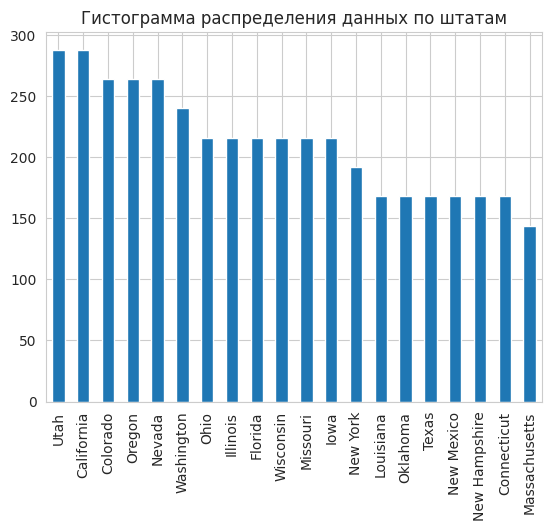

In [ ]:
sales_data['State'].value_counts().plot(kind='bar')
plt.title('Гистограмма распределения данных по штатам')
plt.show()

Данные распределены с определёнными шагами, что даёт основания полагать, что есть полные статистики по условной паре магазин-продукт за весь период. Также данных по каждому штату достаточно для формирования репрезентативной выборки.

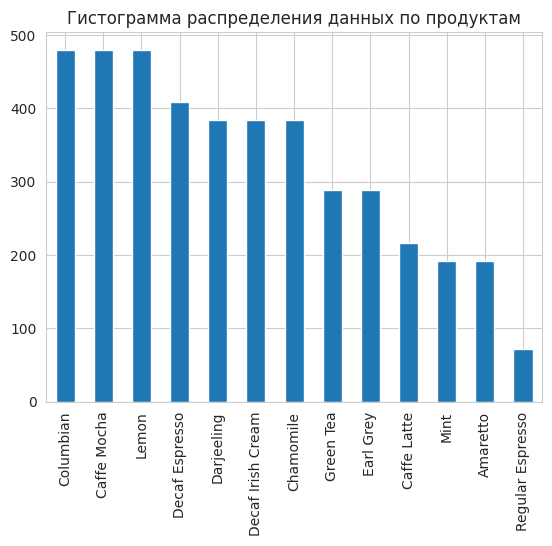

In [ ]:
sales_data['Product'].value_counts().plot(kind='bar')
plt.title('Гистограмма распределения данных по продуктам')
plt.show()

В наиболее популярных категориях из датасета данным в ~5 раз больше, чем в наименее популярных, так что нужно достроить ещё одну диаграмму, чтобы понять распрделенеие по уже интересующим нас параметрам.

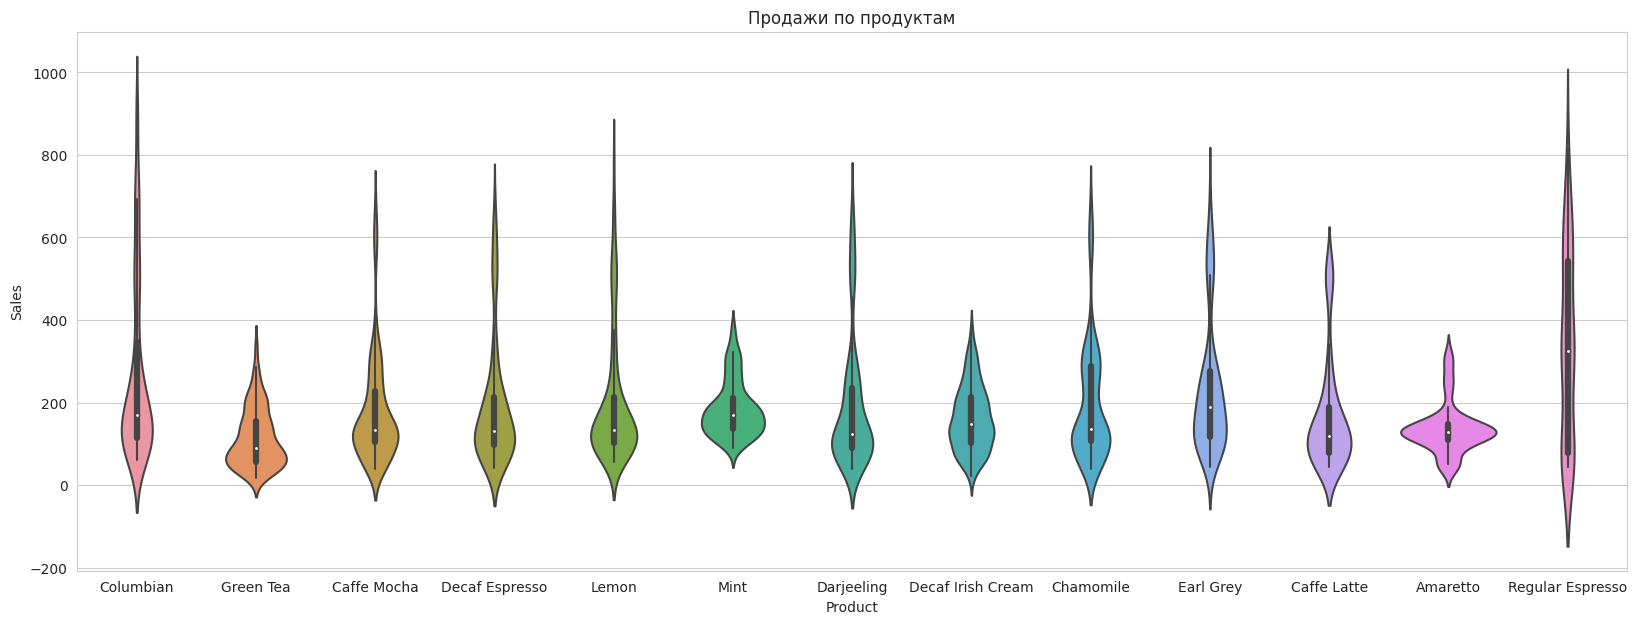

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Продажи по продуктам')
sns.violinplot(data=sales_data, x='Product', y=sales_data['Sales'].astype(float))
plt.show()

Ящик со скрипками показывает, что для большинства категорий зарактерно логичтичесоке рапределение. Ислючение состовляет Regular Espresso с большим разбросом 25/75 и почти без выбросов и Decaf Irish Cream, для которого плот похож на нормально рапределение.

Превосходно, теперь изучим кореляции между значеними

In [ ]:
sales_data['Month'] = sales_data['Date'].apply(lambda x : x.month)
sales_data.corr(numeric_only=True)

,Area Code,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Month
Area Code,1.000000,0.013979,0.029278,0.055220,0.080471,0.044552,0.051232,0.082893,0.011994,0.063720,0.022871,0.042572,2.429694e-02,1.348084e-02
Profit,0.013979,1.000000,0.920604,0.797331,0.464838,0.199976,0.225465,-0.035389,0.937606,0.479862,0.876844,0.758830,-5.869339e-02,8.030853e-03
Margin,0.029278,0.920604,1.000000,0.938809,0.678797,0.521254,0.531947,0.123208,0.922812,0.680549,0.963460,0.901981,-7.959521e-02,1.276869e-02
Sales,0.055220,0.797331,0.938809,1.000000,0.886651,0.689350,0.710515,0.386915,0.815435,0.862882,0.920757,0.956538,-4.807745e-02,1.071546e-02
COGS,0.080471,0.464838,0.678797,0.886651,1.000000,0.782534,0.818271,0.667762,0.514967,0.947762,0.688587,0.849901,2.142304e-03,1.463609e-02
Total Expenses,0.044552,0.199976,0.521254,0.689350,0.782534,1.000000,0.966167,0.471480,0.255811,0.744259,0.530776,0.661217,-7.336890e-02,6.231384e-03
Marketing,0.051232,0.225465,0.531947,0.710515,0.818271,0.966167,1.000000,0.534155,0.279315,0.773709,0.543039,0.681946,-4.222699e-02,1.377227e-02
Inventory,0.082893,-0.035389,0.123208,0.386915,0.667762,0.471480,0.534155,1.000000,0.037206,0.619266,0.177629,0.385972,4.001659e-02,1.321218e-01
Budget Profit,0.011994,0.937606,0.922812,0.815435,0.514967,0.255811,0.279315,0.037206,1.000000,0.579176,0.949637,0.848285,-1.477584e-01,7.596332e-03
Budget COGS,0.063720,0.479862,0.680549,0.862882,0.947762,0.744259,0.773709,0.619266,0.579176,1.000000,0.750422,0.911598,-1.566830e-01,8.278223e-03


In [ ]:
data_corr = sales_data.corr(numeric_only=True)
data_corr[data_corr > 0.5] = 'c'
data_corr

,Area Code,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Month
Area Code,c,0.013979,0.029278,0.05522,0.080471,0.044552,0.051232,0.082893,0.011994,0.06372,0.022871,0.042572,0.024297,0.013481
Profit,0.013979,c,c,c,0.464838,0.199976,0.225465,-0.035389,c,0.479862,c,c,-0.058693,0.008031
Margin,0.029278,c,c,c,c,c,c,0.123208,c,c,c,c,-0.079595,0.012769
Sales,0.05522,c,c,c,c,c,c,0.386915,c,c,c,c,-0.048077,0.010715
COGS,0.080471,0.464838,c,c,c,c,c,c,c,c,c,c,0.002142,0.014636
Total Expenses,0.044552,0.199976,c,c,c,c,c,0.47148,0.255811,c,c,c,-0.073369,0.006231
Marketing,0.051232,0.225465,c,c,c,c,c,c,0.279315,c,c,c,-0.042227,0.013772
Inventory,0.082893,-0.035389,0.123208,0.386915,c,0.47148,c,c,0.037206,c,0.177629,0.385972,0.040017,0.132122
Budget Profit,0.011994,c,c,c,c,0.255811,0.279315,0.037206,c,c,c,c,-0.147758,0.007596
Budget COGS,0.06372,0.479862,c,c,c,c,c,c,c,c,c,c,-0.156683,0.008278


Ячейка выше понадобится на этапе подготовки данных для машинного обучения.

[Text(0.5, 1.0, 'Heatmap of financial parameters relation')]

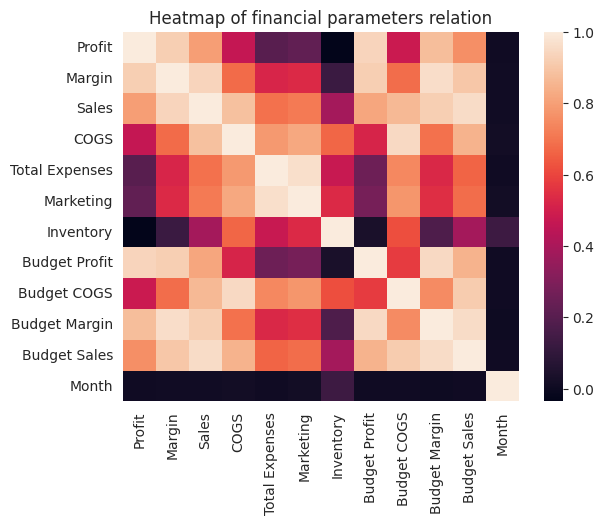

In [ ]:
corr = sales_data.drop(columns=['ProductId', 'Area Code']).corr(numeric_only=True)
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns).set(title='Heatmap of financial parameters relation')

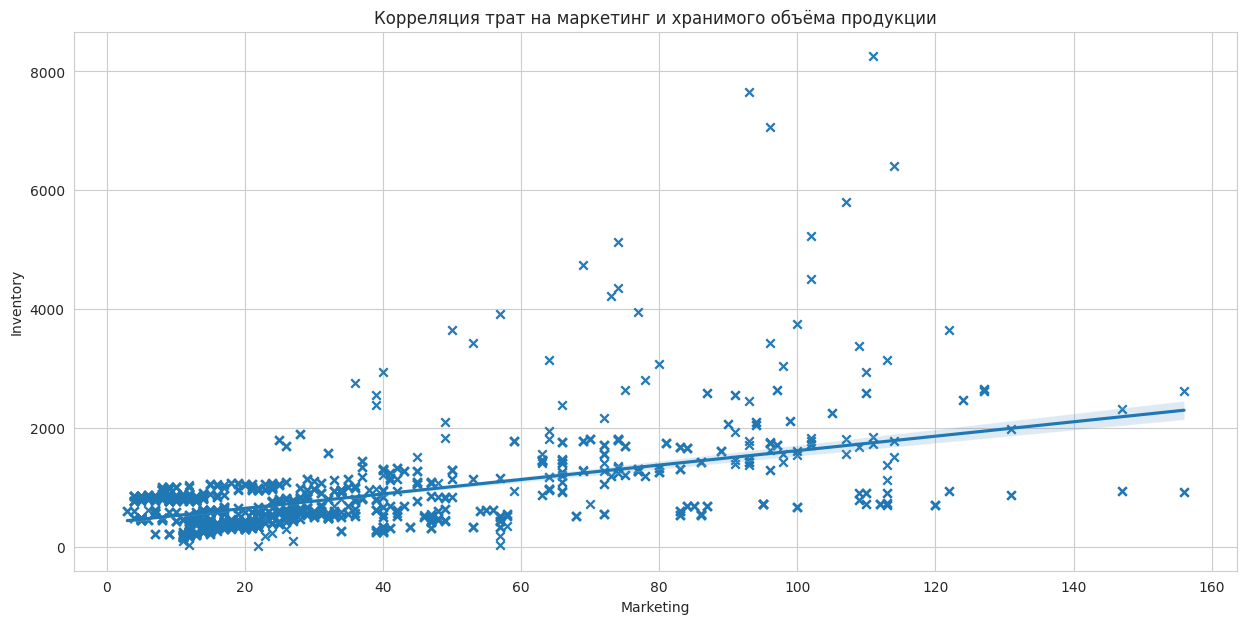

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Корреляция трат на маркетинг и хранимого объёма продукции')

plt.xlabel('Маркетинг (USD$)')
plt.ylabel('Объём(ед.)')

sns.regplot(
    x=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None),
    y=sales_data['Inventory'].astype('float64').apply(lambda x : x if x > 0 else None),
    marker='x')

plt.show()

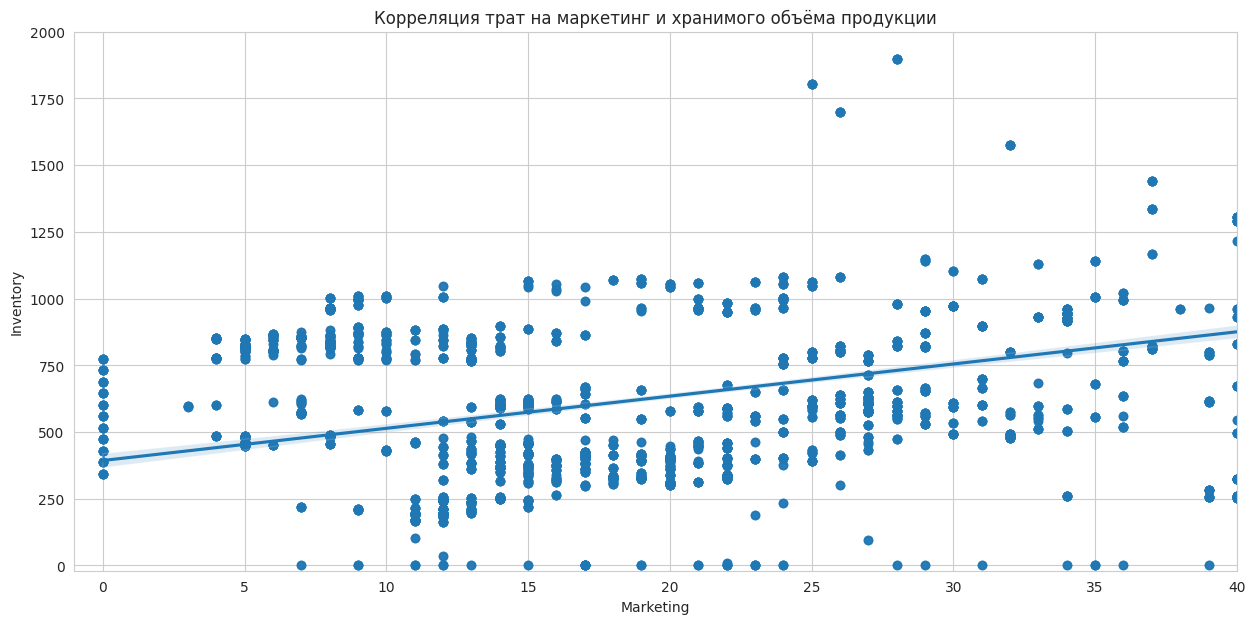

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Корреляция трат на маркетинг и хранимого объёма продукции')

plt.xlabel('Маркетинг (USD$)')
plt.ylabel('Объём(ед.)')

graphobj = sns.regplot(
    x=sales_data['Marketing'].astype('float64'),
    y=sales_data['Inventory'].astype('float64'))

graphobj.set(xlim=(-1, 40), ylim=(-20, 2000))

plt.show()

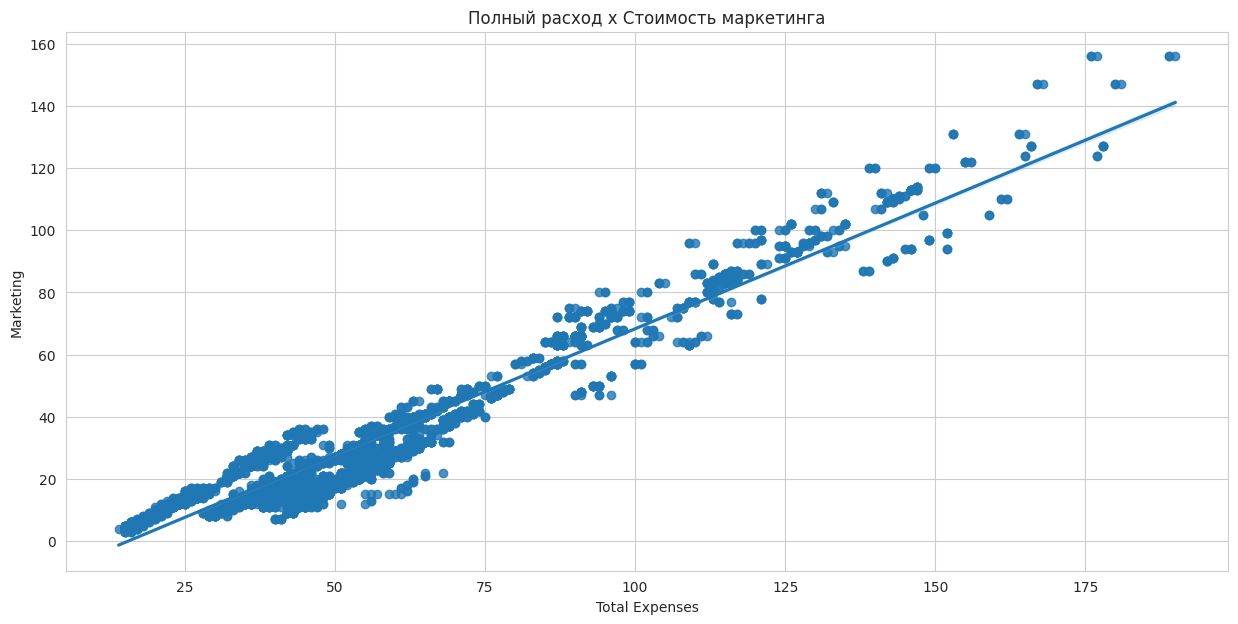

In [ ]:
# Total Expenses - Marketing (Лин. коэф.: 96.66%)

plt.figure(figsize=(15,7))
plt.title('Полный расход x Стоимость маркетинга')

plt.xlabel('Расход (U$)')
plt.ylabel('Маркетинг (U$)')

sns.regplot(
    x=sales_data['Total Expenses'].astype('float64').apply(lambda x : x if x > 0 else None),
    y=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None))

plt.show()

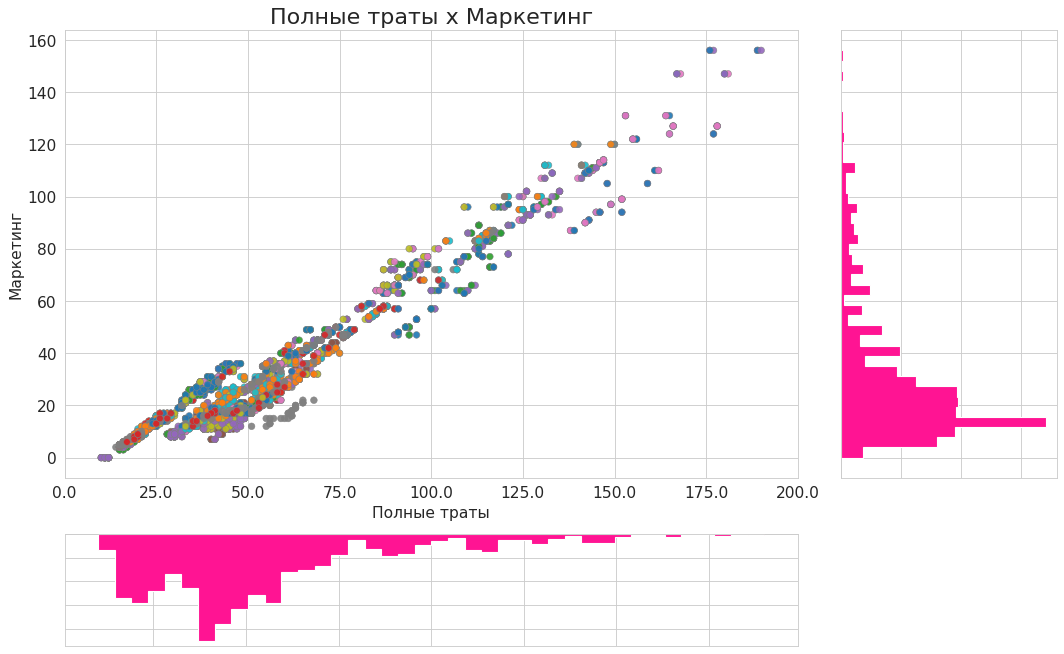

In [ ]:
# Создаём холст и сетку
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

scatter = ax_main.scatter('Total Expenses', 'Marketing', c=sales_data['State'].astype('category').cat.codes, alpha=.9, data=sales_data, cmap="tab10", edgecolors='gray', linewidths=.5)

ax_bottom.hist(sales_data['Total Expenses'], 40, histtype='stepfilled', orientation='vertical', color='deeppink')
ax_bottom.invert_yaxis()

ax_right.hist(sales_data['Marketing'], 40, histtype='stepfilled', orientation='horizontal', color='deeppink')

# Decorations
ax_main.set(title='Полные траты x Маркетинг', xlabel='Полные траты', ylabel='Маркетинг')
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax_main.get_xticks().tolist()
ax_main.xaxis.set_ticks(xlabels)
ax_main.set_xticklabels(xlabels);
plt.show();

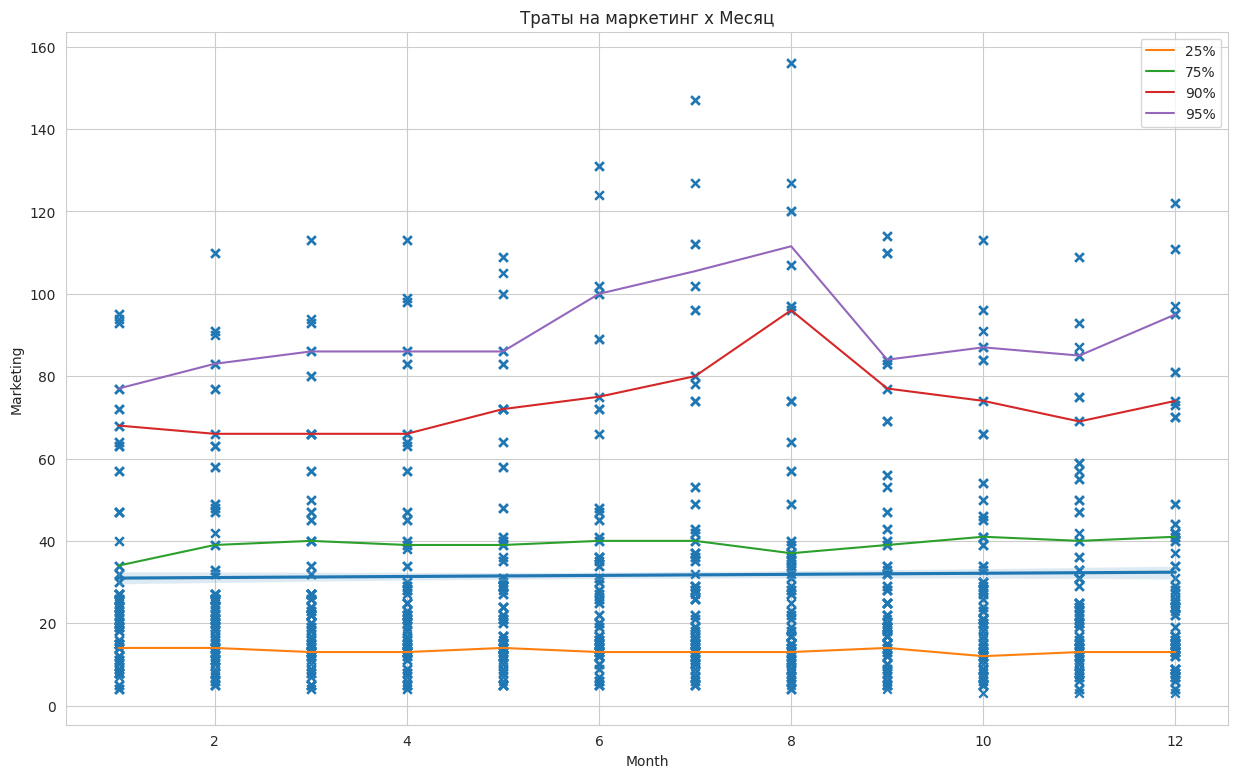

In [ ]:
plt.figure(figsize=(15, 9))

plt.title('Траты на маркетинг x Месяц')

plt.xlabel('Месяц')
plt.ylabel('Траты на Маркетинг (U$)')

sns.regplot(
    y=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None),
    x=sales_data['Month'].astype('float64').apply(lambda x : x if x > 0 else None),
    marker='x')

sales_data.groupby('Month').quantile(q=0.25, numeric_only=True)['Marketing'].plot(label='25%', legend=True);
sales_data.groupby('Month').quantile(q=0.75, numeric_only=True)['Marketing'].plot(label='75%', legend=True);
sales_data.groupby('Month').quantile(q=0.9, numeric_only=True)['Marketing'].plot(label='90%', legend=True);
sales_data.groupby('Month').quantile(q=0.95, numeric_only=True)['Marketing'].plot(label='95%', legend=True);

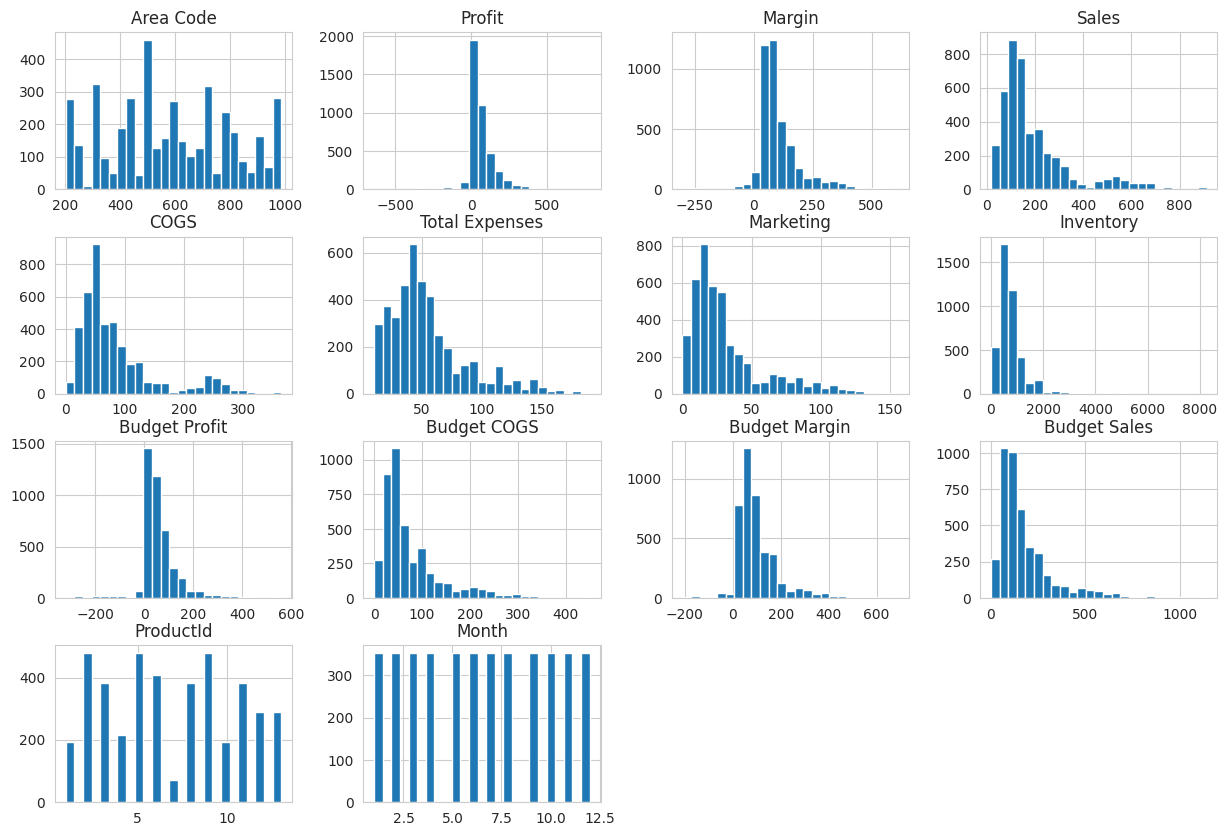

In [ ]:
sales_data.hist(bins=25, figsize=(15, 10));

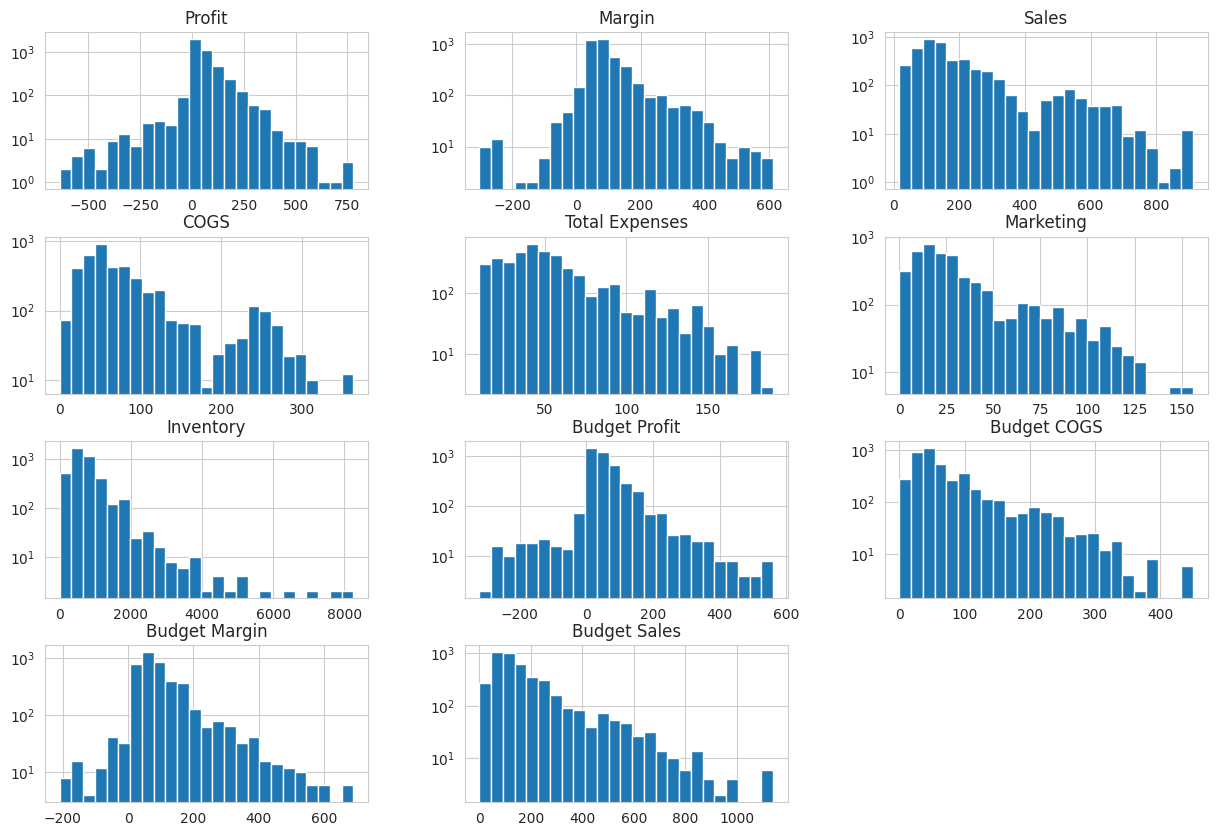

In [ ]:
sales_data.drop(columns=['Area Code', 'ProductId', 'Month']).hist(bins=25, figsize=(15, 10), log=True);

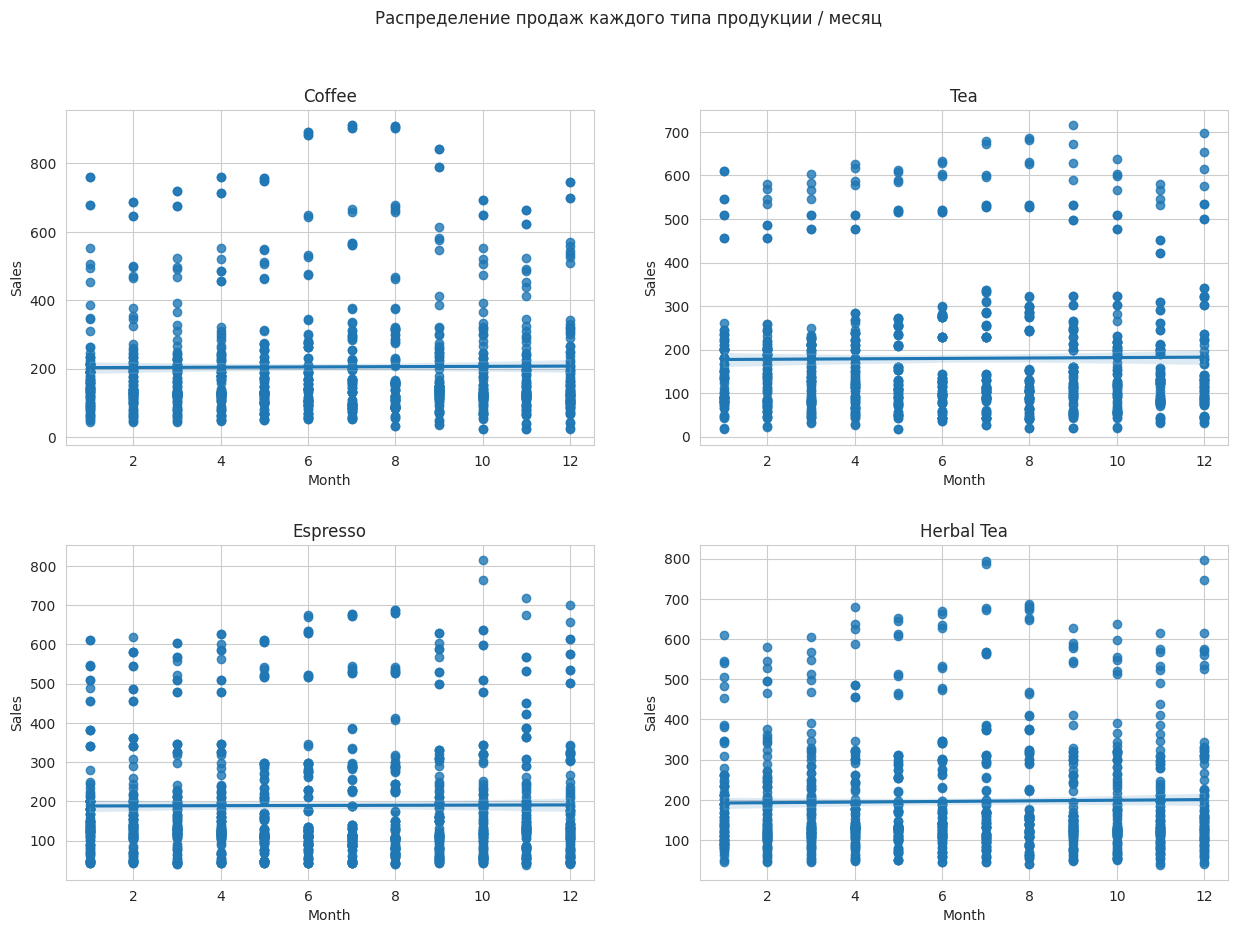

In [ ]:
# Product Type: ['Coffee' 'Tea' 'Espresso' 'Herbal Tea']
def type_x_month_sale_distribution(category_name):
    plt.title(category_name)
    plt.ylabel('Продажи ($)')
    plt.xlabel('Месяц')
    sub_data = sales_data.loc[sales_data['Product Type'] == category_name]
    sns.regplot(y=sub_data['Sales'].astype(float), x=sub_data['Month'])


fig = plt.figure(figsize=(15,10))
fig.suptitle("Распределение продаж каждого типа продукции / месяц")

product_types = ['Coffee', 'Tea', 'Espresso', 'Herbal Tea']
for i in range(4):
    plt.subplot(2, 2, i+1)
    type_x_month_sale_distribution(product_types[i])

plt.subplots_adjust(hspace=0.3)
plt.show()

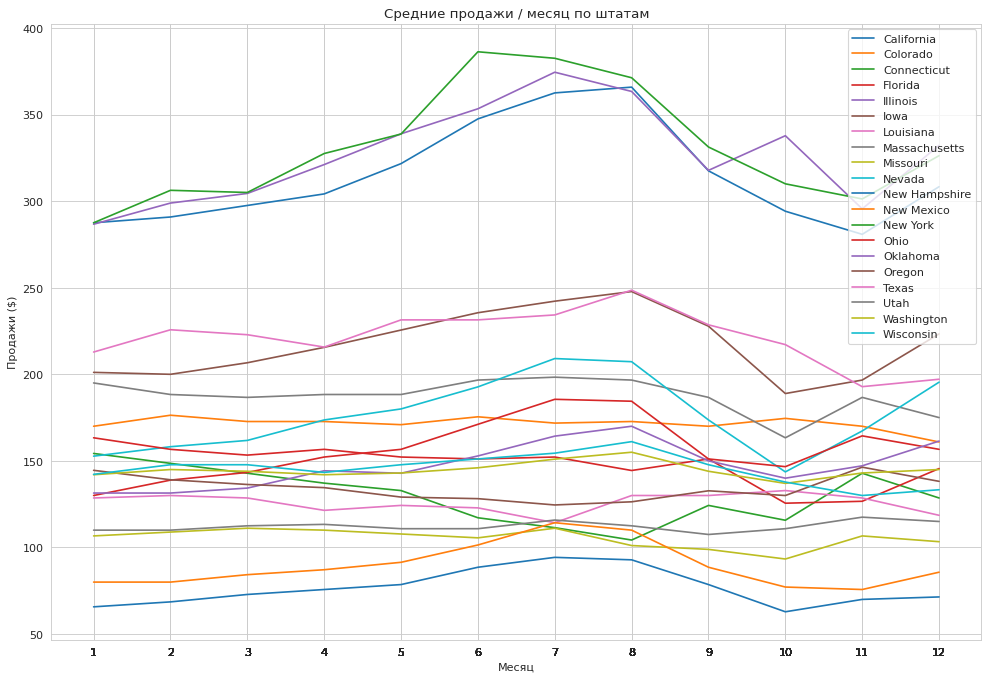

In [ ]:
# group_data = sales_data.groupby(['State','Month'])['Sales'].sum()
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)

sales_trend_data = sales_data.groupby(['State', 'Month']).mean(numeric_only=True)
sales_trend_data = sales_trend_data.reset_index()
sales_trend_data.set_index(['Month', 'State'], inplace=True)
sales_trend_data['Budget Sales'].groupby('State').plot(
    legend=True)
sales_trend_data = sales_trend_data.reset_index()
sales_trend_data.set_index('Month', inplace=True)
ax.set_xticks(sales_trend_data.index-1)
sales_trend_data = sales_trend_data.reset_index()
ax.set_xticklabels(sales_trend_data['Month'])
plt.title('Средние продажи / месяц по штатам')
plt.ylabel('Продажи ($)')
plt.xlabel('Месяц')
plt.show()
# sales_trend_data['Budget Sales'].plot.bar(legend=True)

График не слишком прост из-за нагромождённости, надо это исправить

In [ ]:
states = sales_data['State'].unique()
states_chunks = [states[i*5:(i+1)*5] for i in range(4)]
states_chunks

[array(['Connecticut', 'Washington', 'California', 'Texas', 'New York'],
       dtype=object),
 array(['Ohio', 'Illinois', 'Louisiana', 'Florida', 'Wisconsin'],
       dtype=object),
 array(['Colorado', 'Missouri', 'Iowa', 'Massachusetts', 'Oklahoma'],
       dtype=object),
 array(['Utah', 'Oregon', 'New Mexico', 'New Hampshire', 'Nevada'],
       dtype=object)]

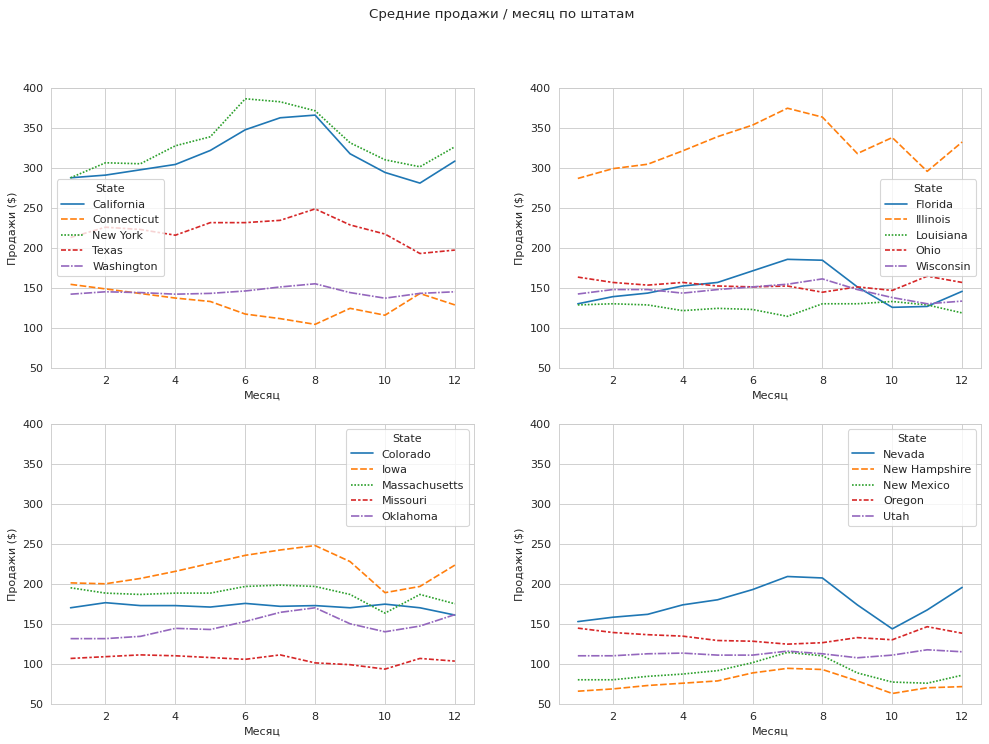

In [ ]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.suptitle('Средние продажи / месяц по штатам')

for i, states in enumerate(states_chunks):
    plt.subplot(2, 2, i + 1)
    sales_trend_data = sales_data[sales_data['State'].isin(states)].pivot_table(values='Budget Sales', index='Month', columns='State', aggfunc='mean')
    graphobj = sns.lineplot(data=sales_trend_data)
    graphobj.set(ylim=(50, 400))  # Выравниваем для одинаковго масштаба
    sales_trend_data = sales_trend_data.reset_index()
    plt.ylabel('Продажи ($)')
    plt.xlabel('Месяц')
plt.show()

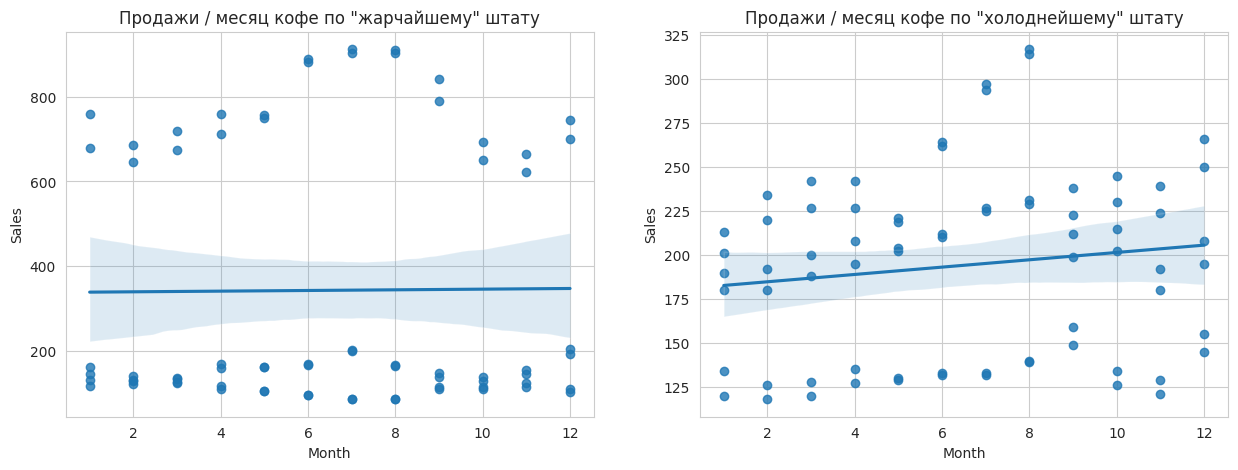

In [ ]:
#State: ['Connecticut' 'Washington' 'California' 'Texas' 'New York' 'Ohio' 'Illinois' 'Louisiana' 'Florida' 'Wisconsin' 'Colorado' 'Missouri' 'Iowa' 'Massachusetts' 'Oklahoma' 'Utah' 'Oregon' 'New Mexico' 'New Hampshire' 'Nevada']
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('')
# One of the hottest
plt.title('Продажи / месяц кофе по "жарчайшему" штату')
plt.ylabel('Sales ($)')
sub_data = sales_data.loc[sales_data['Product Type'] == 'Coffee'].loc[sales_data['State'] == 'California']
sns.regplot(y=sub_data['Sales'].astype(float), x=sub_data['Month'])

plt.subplot(1, 2, 2)
# one of the coldest
plt.title('Продажи / месяц кофе по "холоднейшему" штату')
plt.ylabel('Sales ($)')
sub_data = sales_data.loc[sales_data['Product Type'] == 'Coffee'].loc[sales_data['State'] == 'Wisconsin']
sns.regplot(y=sub_data['Sales'].astype(float), x=sub_data['Month'])

plt.show()

При этом остался один важный вопрос: а как на выручку влияет `год`? От года не зависят сезонные факторы, но он явно может давать нам подсказки о различной инфляции, ППС и ВВП, что косвенно вляет на данные.

In [ ]:
sales_data['Date'].value_counts()

2010-04    177
2010-07    177
2011-06    177
2010-09    177
2010-03    177
2010-08    177
2010-05    177
2010-02    177
2011-12    177
2011-05    177
2011-04    177
2011-03    177
2011-02    177
2011-01    177
2010-10    177
2010-06    177
2011-11    177
2011-10    177
2011-09    177
2011-08    177
2011-07    177
2010-12    177
2010-11    177
2010-01    177
Freq: M, Name: Date, dtype: int64

Ок, данные по годам/месяца распрделены абсолютно равномерно, можем ехать дальше

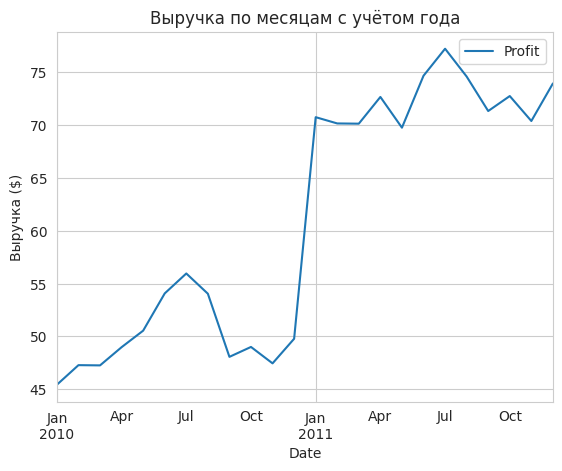

In [ ]:
sales_data.pivot_table(index='Date', values='Profit', aggfunc='mean').plot()
plt.title('Выручка по месяцам с учётом года')
plt.ylabel('Выручка ($)')
plt.show()

**Вау!** Средняя выручка выросла почти в два раза, при этом резким скачком. Это значит, что год точно можно использовать как один из факторов, но только сначала стоит проверить данные на равном сэмпле.

<ipython-input-34-14b77aa2e488>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_by_month_in_one_area.sort_values(by='Date', inplace=True)


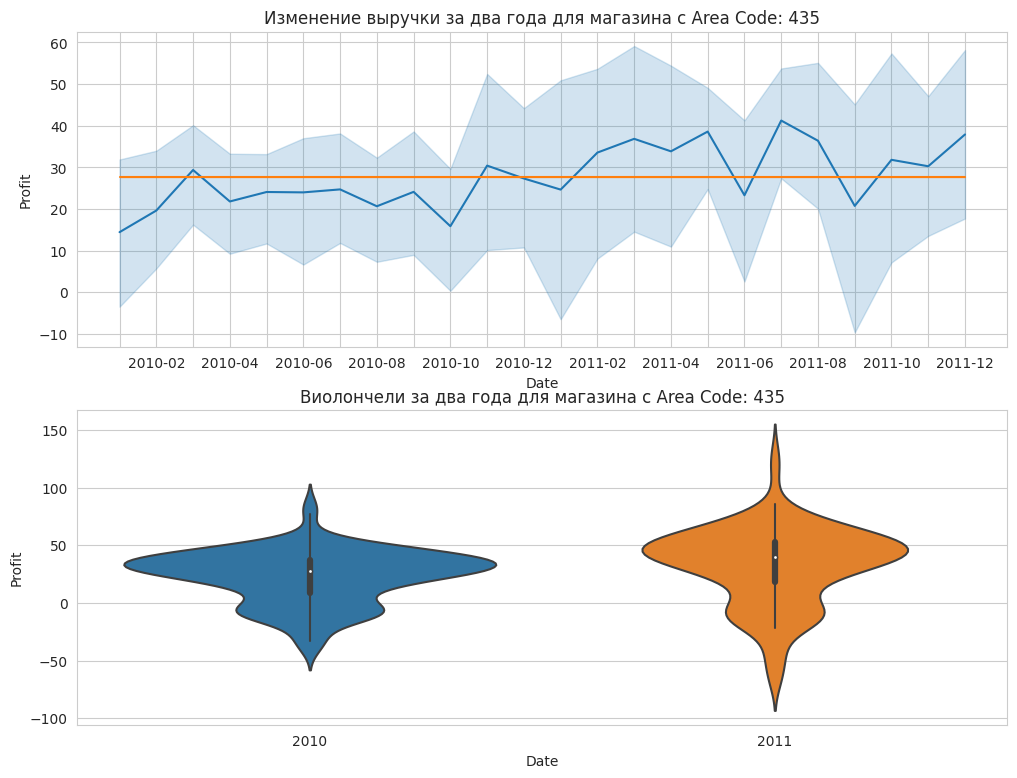

In [ ]:
most_common_area_code = sales_data['Area Code'].mode()

sales_by_month_in_one_area = sales_data[sales_data['Area Code'].isin(most_common_area_code)]
sales_by_month_in_one_area.sort_values(by='Date', inplace=True)

plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
chart = sns.lineplot(x=sales_by_month_in_one_area['Date'].astype('str'),
             y=sales_by_month_in_one_area['Profit'])
sns.lineplot(x=sales_by_month_in_one_area['Date'].astype('str'), y=sales_by_month_in_one_area['Profit'].mean())
plt.title(f'Изменение выручки за два года для магазина с Area Code: {most_common_area_code.iloc[0]}')
for label in chart.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.subplot(2,1,2)
plt.title(f'Виолончели за два года для магазина с Area Code: {most_common_area_code.iloc[0]}')
sns.violinplot(y=sales_by_month_in_one_area['Profit'].astype(float), x=sales_by_month_in_one_area['Date'].apply(lambda x: x.year))

plt.show()


На графиках видно увеличение выручки за год, при этом больше стала как медиана, так и дисперсия.

## Создание новых признаков


* Есть месяц
* (будет) средняя температура по месяцам в штате
* (будет) бюджет штата/численность населения

In [ ]:
# На всякий случай добавляем задержку, чтобы сайт не занёс нас в чёрный список
time.sleep(0.1)

# Получаем ответ от сайта с погодой в Америке по штату флорида. Используем печеньки, чтобы данные отдавались в Цельсиях и метрах/секунду
response = requests.get('https://weatherspark.com/countries/US/FL', cookies={'unit-set': 'MetricWithMPerS'})
# Используем библиотеку парсинга xml для парсинга нашей странички на теги
soup = bs4.BeautifulSoup(response.text, 'html.parser')
# Посмотрим что за данные у нас есть. Для этого вытаскиваем класс таблицы с данными и подставляем его в селектор
# После этого проходимся по табличкам и достаём их названия
for table in soup.find_all('table', class_="table table-striped table-condensed table-hover nowrap"):
    print(table.thead.tr.th.text)


High
Low
Clearer Skies
Days of Precip.
Rainfall
Daylight
Muggy days
Wind Speed (m/s)
Water Temp.
Solar Energy (kWh)


Превосходно, нам доступны данные по:


*   Температуре
    *   High
    *   Low
*   Облачности
*   Верятности осадков
*   Среднемесячному кол-во осадков
*   Солнечному дню
*   Скорости ветра
*   Температуре воды
*   Среднесуточному выбросу коротковолновой солнечной энергии

Ценой за эти данные становится перевод названия штата в правильное сокращение и парсинг странички с метеоданными


In [ ]:
# Вспомним, какие штаты надо перевести в почтовые коды
sales_data["State"].unique()

array(['Connecticut', 'Washington', 'California', 'Texas', 'New York',
       'Ohio', 'Illinois', 'Louisiana', 'Florida', 'Wisconsin',
       'Colorado', 'Missouri', 'Iowa', 'Massachusetts', 'Oklahoma',
       'Utah', 'Oregon', 'New Mexico', 'New Hampshire', 'Nevada'],
      dtype=object)

In [ ]:
# Многовато, значит воспользуемся сторонним ресурсом

# Готовим список штатов, для которых нужно получить коды
states_list = list(sales_data["State"].unique())
# Готовим словарь под пары штат - код
states_to_postcode = dict()

# Проходимся по табличке на сайте и если в ячейке стоит название нужного нам штата записываем себе его посткод
response = requests.get('https://www.americancities.ru/info/capital_cities/')
american_soup = bs4.BeautifulSoup(response.text, 'html.parser')
for row in american_soup.find('table', class_="stat").find_all('tr')[1:]:
    state, short, post, capital = row.find_all('td')
    eng_state = state.text.split('(')[0].strip()
    if eng_state in states_list:
        states_to_postcode[eng_state] = post.text

# Красивый вывод словаря
print(json.dumps(states_to_postcode, indent=4))

{
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Florida": "FL",
    "Illinois": "IL",
    "Iowa": "IA",
    "Louisiana": "LA",
    "Massachusetts": "MA",
    "Missouri": "MO",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Mexico": "NM",
    "New York": "NY",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Texas": "TX",
    "Utah": "UT",
    "Washington": "WA",
    "Wisconsin": "WI"
}


In [ ]:
# Узнаем, что нам отдаст сервис, если посткод не подойдёт
# allow_redirects=False позволит узнать именно тот код, который отдал сервис
response_code = requests.get(f'https://weatherspark.com/countries/US/ST', cookies={'unit-set': 'MetricWithMPerS'}, allow_redirects=False).status_code
response_code

303

In [ ]:
# Теперь попробуем сходить с каждым кодом в метеосервис, и проверим, что наждый вернёт OK
for state, code in states_to_postcode.items():
    time.sleep(0.1) # Не забываем о защите от фаервола
    response_code = requests.get(f'https://weatherspark.com/countries/US/{code}', cookies={'unit-set': 'MetricWithMPerS'}, allow_redirects=False).status_code
    print(state, response_code)

California 200
Colorado 200
Connecticut 200
Florida 200
Illinois 200
Iowa 200
Louisiana 200
Massachusetts 200
Missouri 200
Nevada 200
New Hampshire 200
New Mexico 200
New York 200
Ohio 200
Oklahoma 200
Oregon 200
Texas 200
Utah 200
Washington 200
Wisconsin 200


In [ ]:
# ОСТОРОЖНО ДОЛГАЯ ЯЧЕЙКА С ВАЖНЫЙ
# Теперь пройдёмся по штатам и соберём данные в датасет
# Определяем пустой словарь с погодными данными
weather = {}
# проходимся по каждому штату
for state, code in states_to_postcode.items():
    time.sleep(0.1) # Не забываем о защите от фаервола
    response = requests.get(f'https://weatherspark.com/countries/US/{code}', cookies={'unit-set': 'MetricWithMPerS'})
    response.encoding = 'utf-8'  # Тут полетела кодировка, надо исправить
    state_soup = bs4.BeautifulSoup(response.text, 'html.parser')
    datatables = state_soup.find_all('table', class_="table table-striped table-condensed table-hover nowrap")
    # Проходимся по каждой табличке
    for datatable in datatables:
        parameter_name = datatable.thead.tr.th.text
        # По каждому городу
        for town in datatable.tbody.find_all('tr'):
            # И по каждому значению
            for idx, value in enumerate(town.find_all('td')[1:]):
                # Теперь по ключу штат-город-месяц лежит словарь параметр-значение
                # Такое решение необходимо, так как не для всех городов предоставлены все данные
                weather.setdefault((state, town.td.text.strip(), idx+1), {}).update({parameter_name: value.text})

list(weather.items())[0]

(('California', 'Los Angeles', 1),
 {'High': '20°C',
  'Low': '9°C',
  'Clearer Skies': '61%',
  'Days of Precip.': '5.2d',
  'Rainfall': '67.0mm',
  'Daylight': '10.2h',
  'Muggy days': '0.0d',
  'Wind Speed (m/s)': '3.7',
  'Water Temp.': '15°C',
  'Solar Energy (kWh)': '3.3'})

In [ ]:
# High
# Low
# Clearer Skies
# Days of Precip.
# Rainfall
# Daylight
# Muggy days
# Wind Speed (m/s)
# Water Temp.
# Solar Energy (kWh)
weather_data = pd.DataFrame(
    data=weather.keys(),
    columns=['State', 'Town', 'Month']
)
for k, v in weather.items():
    state, town, month = k
    for column, value in v.items():
        weather_data.loc[
            (weather_data['State'] == state) &
            (weather_data['Town']==town) &
            (weather_data['Month']==month), column] = value
weather_data

,State,Town,Month,High,Low,Clearer Skies,Days of Precip.,Rainfall,Daylight,Muggy days,Wind Speed (m/s),Water Temp.,Solar Energy (kWh),Snowfall
0,California,Los Angeles,1,20°C,9°C,61%,5.2d,67.0mm,10.2h,0.0d,3.7,15°C,3.3,NaN
1,California,Los Angeles,2,20°C,10°C,58%,5.4d,84.4mm,11.0h,0.0d,3.5,15°C,4.2,NaN
2,California,Los Angeles,3,21°C,11°C,64%,4.4d,53.4mm,12.0h,0.0d,3.3,15°C,5.7,NaN
3,California,Los Angeles,4,22°C,13°C,73%,2.0d,19.3mm,13.1h,0.0d,3.2,15°C,7.1,NaN
4,California,Los Angeles,5,23°C,15°C,78%,0.8d,5.5mm,14.0h,0.0d,2.9,17°C,8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,Wisconsin,Superior,8,24°C,14°C,69%,10.6d,79.4mm,14.1h,5.0d,3.7,16°C,5.9,0.0mm
740,Wisconsin,Superior,9,19°C,10°C,62%,9.3d,78.9mm,12.5h,1.5d,4.2,14°C,4.4,0.1mm
741,Wisconsin,Superior,10,12°C,4°C,52%,7.2d,54.2mm,10.8h,0.0d,4.5,10°C,2.9,12.8mm
742,Wisconsin,Superior,11,4°C,-3°C,45%,4.8d,27.8mm,9.4h,0.0d,4.5,6°C,1.7,70.5mm


In [ ]:
# Есть ячейки со значениями Nan и это неудобно
weather_data = weather_data.replace(np.nan, None)

In [ ]:
celsium_columns = ['High', 'Low', 'Water Temp.']

for column in celsium_columns:
    weather_data[column + ' (°C)'] = weather_data[column].apply(
        lambda x : int(x[:-2]) if x else None)

weather_data.describe()

,Month,High (°C),Low (°C),Water Temp. (°C)
count,744.000000,744.000000,744.000000,300.000000
mean,6.500000,19.068548,8.393817,14.993333
std,3.454375,9.773994,9.103976,7.743805
min,1.000000,-5.000000,-15.000000,1.000000
25%,3.750000,12.000000,1.750000,9.000000
50%,6.500000,20.000000,9.000000,15.000000
75%,9.250000,27.000000,15.000000,20.250000
max,12.000000,41.000000,27.000000,30.000000


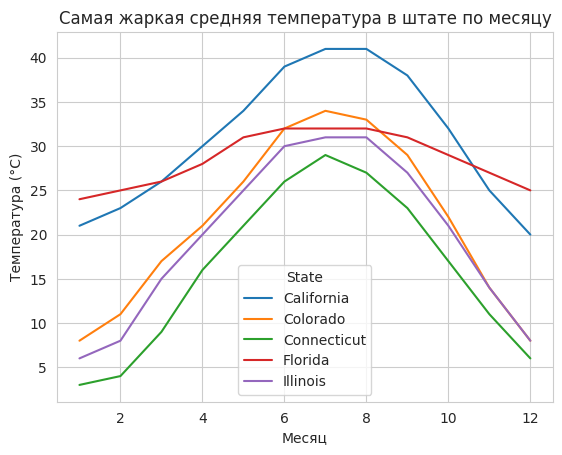

In [ ]:
# Посмотрим на график самой жаркой температуры по каждому штату
hottest_states = weather_data.pivot_table(values='High (°C)', index='State',
                                          aggfunc='max').index[:5].to_list()
weather_data[weather_data['State'].isin(hottest_states)].groupby(
    ['State', 'Month'])['High (°C)'].max().unstack('State').plot(
    title='Самая жаркая средняя температура в штате по месяцу',
    ylabel='Температура (°C)',
    xlabel='Месяц',
);

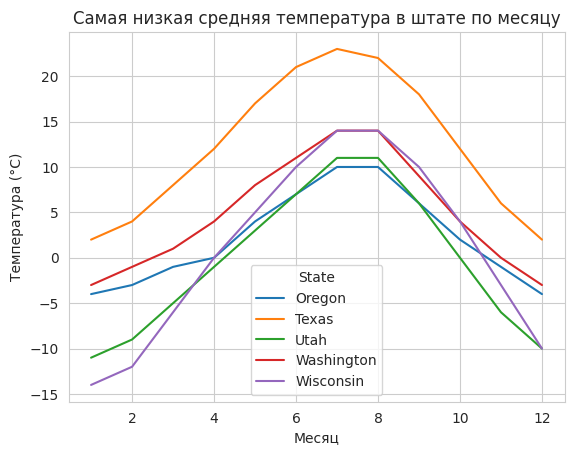

In [ ]:
# Посмотрим на график самой холодной температуры по каждому штату
coldest_states = weather_data.pivot_table(values='Low (°C)', index='State',
                                          aggfunc='min').index[-5:].to_list()
weather_data[weather_data['State'].isin(coldest_states)].pivot_table(
    values='Low (°C)', index='Month', columns='State', aggfunc='min').plot(
    title='Самая низкая средняя температура в штате по месяцу',
    ylabel='Температура (°C)',
    xlabel='Месяц',
);

Теперь есть немного данных, асоциированных к паре штат-месяц. На данном этапе работа с ними закончена, и они будут использованы (или не будут) когда мы оценим их скореллированнность с остальными.

In [ ]:
response = requests.get('https://worldpopulationreview.com/states')
soup = bs4.BeautifulSoup(response.text, 'html.parser')
population_data = pd.DataFrame(
    json.loads(
        soup.find(
            'script', id='__NEXT_DATA__'
            ).text
        )['props']['pageProps']['data']
    )
population_data.head()

,fips,state,densityMi,pop2023,pop2022,pop2020,pop2019,pop2010,growthRate,growth,growthSince2010,area,rank
0,6,California,249.81347,38915693,39029342,39501653,39276883.3,37253956,-0.00291,-113649,0.04461,155779,1
1,48,Texas,116.75553,30500280,30029572,29232474,28823782.7,25145561,0.01567,470708,0.21295,261232,2
2,12,Florida,422.59351,22661577,22244823,21589602,21310772.8,18801310,0.01873,416754,0.20532,53625,3
3,36,New York,413.71663,19496810,19677151,20108296,20035276.6,19378102,-0.00916,-180341,0.00613,47126,4
4,42,Pennsylvania,289.02749,12931957,12972008,12994440,12965233.9,12702379,-0.00309,-40051,0.01807,44743,5


Отсюда нас интересует популяция на момент 2010 года и площадь штата.

## Гипотезы


1. Летом возрастает стоимость крупных закупок.
2. Штат влияет на продажи, в т.ч. на дифференциацию аннуальных продаж
 * [MI-анализ показывает, что есть связь между отдельным aread-state и выручкой](#scrollTo=Gg2k9kJIAoSp)
 * [Корреляция между числом жителей штата и профитом 0.27, продажами - 0.34 ](#scrollTo=_ML)

## Машинное обучение

### Фича-факторинг

In [ ]:
# Будем использовать отображение на числовой окружности для месяцов, чтобы
# декабрь был ближе к январю, чем к августу (анимашка -- вам)
# Для просмотра в github (или другой плотформе, не поддерживающей виджеты,
# используйте ссылку)
IPython.display.IFrame('https://www.desmos.com/calculator/mxzw3mnvqg?embed',
                       500, 500)

1. Попробуем линейную регрессию
2. Качество модели оценим по RMSE

In [ ]:
X = sales_data.copy()

In [ ]:
for column in ['Low (°C)', 'High (°C)']:
    X[column] = 0
    for month, row in weather_data.pivot_table(values=column, index='Month',
                                               columns='State', aggfunc='mean'
                                               ).iterrows():
        for state, value in row.items():
            X.loc[(X['Month'] == month) & (X['State'] == state), [column]] = value

In [ ]:
X['Population'] = 0
for state, row in population_data.iterrows():
    X.loc[X['State'] == row.state, ['Population']] = row.pop2010

In [ ]:
X

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,...,Budget Sales,ProductId,Date,Product Type,Product,Type,Month,Low (°C),High (°C),Population
0,203,Connecticut,East,Small Market,107,176,292,116,69,38,...,270,2,2010-04,Coffee,Columbian,Regular,4,5.000000,15.000000,3574097
1,203,Connecticut,East,Small Market,75,135,225,90,60,29,...,210,2,2010-07,Coffee,Columbian,Regular,7,19.000000,28.000000,3574097
2,203,Connecticut,East,Small Market,122,195,325,130,73,42,...,290,2,2010-11,Coffee,Columbian,Regular,11,2.500000,11.000000,3574097
3,203,Connecticut,East,Small Market,105,174,289,115,69,37,...,260,2,2010-12,Coffee,Columbian,Regular,12,-2.000000,5.500000,3574097
4,203,Connecticut,East,Small Market,104,135,223,90,56,29,...,210,2,2011-07,Coffee,Columbian,Regular,7,19.000000,28.000000,3574097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,985,Louisiana,South,Small Market,-6,66,113,47,72,42,...,90,4,2010-07,Espresso,Caffe Latte,Regular,7,24.333333,33.333333,4533372
4244,985,Louisiana,South,Small Market,-7,61,105,44,68,39,...,90,4,2010-08,Espresso,Caffe Latte,Regular,8,23.666667,33.000000,4533372
4245,985,Louisiana,South,Small Market,-3,76,131,55,79,49,...,100,4,2010-12,Espresso,Caffe Latte,Regular,12,7.333333,17.000000,4533372
4246,985,Louisiana,South,Small Market,1,87,160,63,86,57,...,120,4,2011-04,Espresso,Caffe Latte,Regular,4,15.333333,25.333333,4533372


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   Area Code       4248 non-null   int64    
 1   State           4248 non-null   object   
 2   Market          4248 non-null   object   
 3   Market Size     4248 non-null   object   
 4   Profit          4248 non-null   Int64    
 5   Margin          4248 non-null   Int64    
 6   Sales           4248 non-null   Int64    
 7   COGS            4248 non-null   Int64    
 8   Total Expenses  4248 non-null   Int64    
 9   Marketing       4248 non-null   Int64    
 10  Inventory       4248 non-null   int64    
 11  Budget Profit   4248 non-null   Int64    
 12  Budget COGS     4248 non-null   Int64    
 13  Budget Margin   4248 non-null   Int64    
 14  Budget Sales    4248 non-null   Int64    
 15  ProductId       4248 non-null   int64    
 16  Date            4248 non-null   period[M]


In [ ]:
# Две трансформации, чтобы получить положение месяца на циферблате
X['Month_i'] = np.sin(X['Month']*np.pi/6)
X['Month_j'] = np.cos(X['Month']*np.pi/6)
# Год в бин
X['year_f'] = X['Date'].apply(lambda x : x.year) - 2010
# Месяца в порядок внутри выборки
X['Month_o'] = X['Month'] + X['year_f']*12

###### Корреляции в наборе для ML

In [ ]:
X.corr(numeric_only=True)

,Area Code,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,...,Budget Sales,ProductId,Month,Low (°C),High (°C),Population,Month_i,Month_j,year_f,Month_o
Area Code,1.000000,0.013979,2.927834e-02,0.055220,8.047071e-02,0.044552,5.123189e-02,8.289277e-02,1.199399e-02,6.371986e-02,...,4.257203e-02,2.429694e-02,1.348084e-02,-1.770198e-02,1.551046e-02,4.741237e-02,-7.869583e-03,1.352487e-02,-1.135428e-02,-3.118827e-03
Profit,0.013979,1.000000,9.206041e-01,0.797331,4.648382e-01,0.199976,2.254650e-01,-3.538926e-02,9.376062e-01,4.798618e-01,...,7.588298e-01,-5.869339e-02,8.030853e-03,4.985888e-02,1.931654e-02,2.099461e-01,-1.105256e-02,-1.589717e-02,1.108570e-01,1.000934e-01
Margin,0.029278,0.920604,1.000000e+00,0.938809,6.787967e-01,0.521254,5.319466e-01,1.232082e-01,9.228119e-01,6.805488e-01,...,9.019808e-01,-7.959521e-02,1.276869e-02,7.209016e-02,3.935734e-02,2.743449e-01,-2.027894e-02,-3.568684e-02,-1.170910e-16,6.367666e-03
Sales,0.055220,0.797331,9.388095e-01,1.000000,8.866512e-01,0.689350,7.105149e-01,3.869154e-01,8.154348e-01,8.628820e-01,...,9.565376e-01,-4.807745e-02,1.071546e-02,6.526419e-02,3.613411e-02,3.459105e-01,-1.842381e-02,-2.004160e-02,2.725030e-02,2.896370e-02
COGS,0.080471,0.464838,6.787967e-01,0.886651,1.000000e+00,0.782534,8.182707e-01,6.677617e-01,5.149673e-01,9.477621e-01,...,8.499008e-01,2.142304e-03,1.463609e-02,8.233461e-02,6.427894e-02,3.785483e-01,-2.740525e-02,-4.118350e-02,-2.905668e-16,7.298927e-03
Total Expenses,0.044552,0.199976,5.212543e-01,0.689350,7.825338e-01,1.000000,9.661667e-01,4.714796e-01,2.558112e-01,7.442592e-01,...,6.612171e-01,-7.336890e-02,6.231384e-03,3.328903e-02,1.711722e-02,2.550202e-01,-1.237198e-02,-5.987317e-03,-1.697016e-02,-1.160181e-02
Marketing,0.051232,0.225465,5.319466e-01,0.710515,8.182707e-01,0.966167,1.000000e+00,5.341553e-01,2.793152e-01,7.737093e-01,...,6.819459e-01,-4.222699e-02,1.377227e-02,7.239065e-02,5.290662e-02,3.018000e-01,-2.559065e-02,-3.800123e-02,-2.014358e-16,6.868145e-03
Inventory,0.082893,-0.035389,1.232082e-01,0.386915,6.677617e-01,0.471480,5.341553e-01,1.000000e+00,3.720579e-02,6.192661e-01,...,3.859721e-01,4.001659e-02,1.321218e-01,5.407547e-02,5.282761e-02,2.418124e-01,-1.215702e-01,1.283522e-02,-3.472928e-16,6.588837e-02
Budget Profit,0.011994,0.937606,9.228119e-01,0.815435,5.149673e-01,0.255811,2.793152e-01,3.720579e-02,1.000000e+00,5.791765e-01,...,8.482855e-01,-1.477584e-01,7.596332e-03,7.401240e-02,4.328367e-02,2.233567e-01,-3.008669e-02,-3.493163e-02,-7.795795e-17,3.788245e-03
Budget COGS,0.063720,0.479862,6.805488e-01,0.862882,9.477621e-01,0.744259,7.737093e-01,6.192661e-01,5.791765e-01,1.000000e+00,...,9.115985e-01,-1.566830e-01,8.278223e-03,8.665368e-02,5.971240e-02,4.069253e-01,-1.615120e-02,-4.231467e-02,-2.401126e-16,4.128300e-03


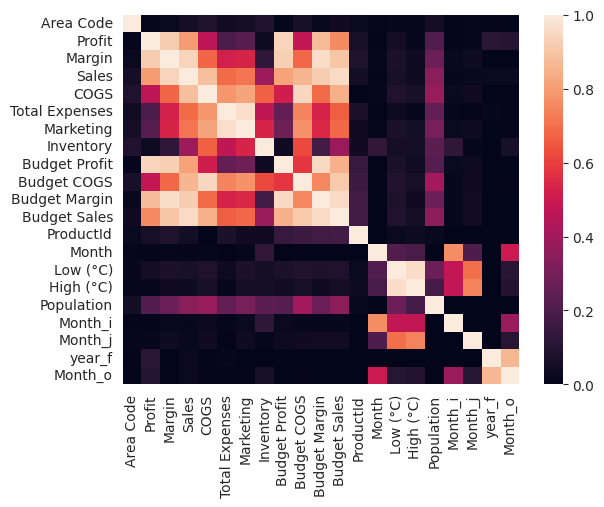

In [ ]:
sns.heatmap(X.corr(numeric_only=True).apply(lambda x : abs(x)))
plt.show()

In [ ]:
X.drop(['Margin', 'Sales', 'Budget Sales', 'Budget Margin', 'Budget COGS', 'Total Expenses', 'High (°C)'], axis=1, inplace=True)

Дропаем сильно зависимые колонки

In [ ]:
y = X.pop('Profit')

Вот и разделение на фичу и предсказываемое значение

In [ ]:
X_discrete_features = [col for col in X.columns
                      if X[col].dtype == 'int64']
X_priceval_features = [col for col in X.columns
                      if X[col].dtype == 'Int64']
X_continuous_features = [col for col in X.columns
                        if X[col].dtype =='float64']

discrete_features = X[X_discrete_features].dtypes == int
priceval_features = X[X_priceval_features].dtypes == int
continuous_features = X[X_continuous_features].dtypes == float

In [ ]:
def plot_mi_scores(scores):
    """
    Plots Mutual Information Scores in Ascending Order
    """
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

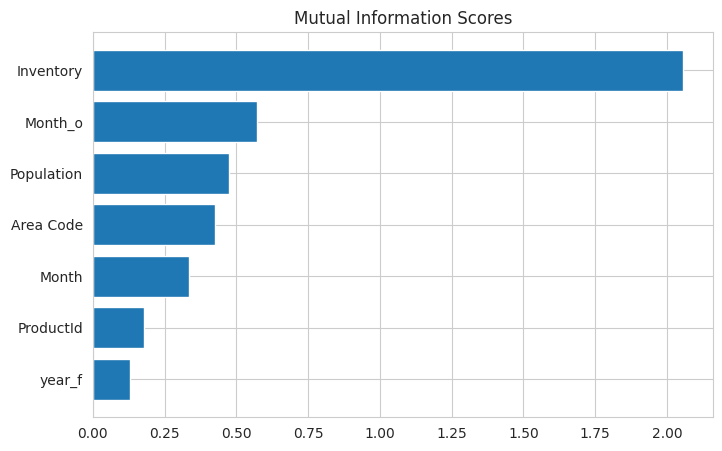

In [ ]:
mi_scores_discrete_features = mutual_info_regression(X[X_discrete_features], y, discrete_features=discrete_features, random_state=2004)
mi_scores_discrete_features = pd.Series(mi_scores_discrete_features, name='MI Scores 1', index=X_discrete_features)
mi_scores_discrete_features = mi_scores_discrete_features.sort_values(ascending=False)

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores_discrete_features)

Число закупаемых товаров сильно влияет на итоговую прибыль, и также большой MI-фактор у порядка месяца

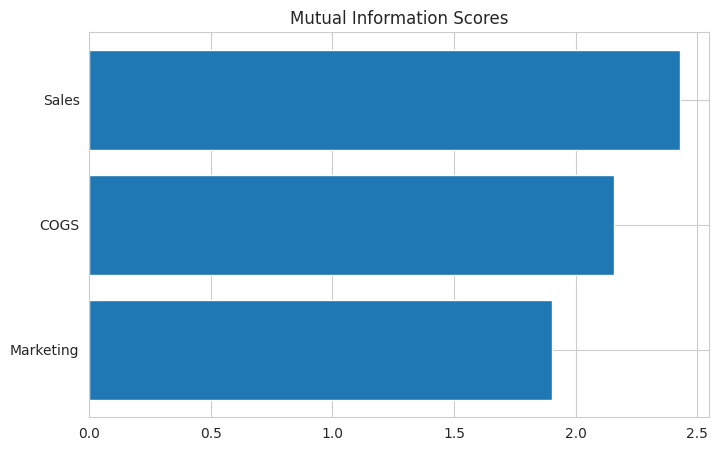

In [ ]:
mi_scores_priceval_features = mutual_info_regression(X[X_priceval_features], y, discrete_features=priceval_features, random_state=2004)
mi_scores_priceval_features = pd.Series(mi_scores_priceval_features, name='MI Scores 2', index=X_priceval_features)
mi_scores_priceval_features = mi_scores_priceval_features.sort_values(ascending=False)

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores_priceval_features)

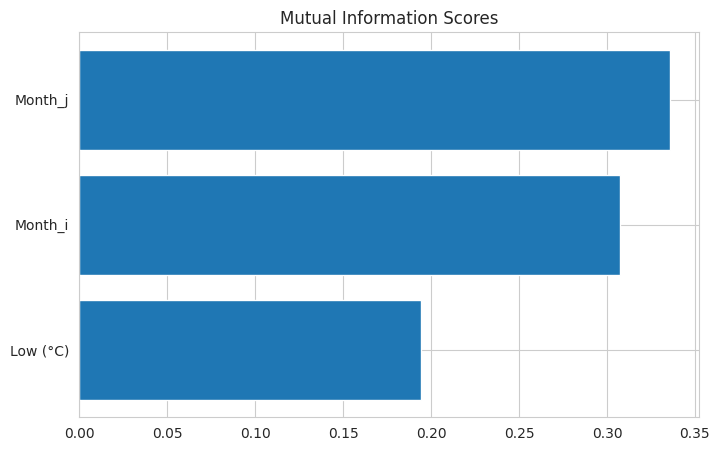

In [ ]:
mi_scores_continuous_features = mutual_info_regression(X[X_continuous_features], y, discrete_features=continuous_features, random_state=2004)
mi_scores_continuous_features = pd.Series(mi_scores_continuous_features, name='MI Scores 3', index=X_continuous_features)
mi_scores_continuous_features = mi_scores_continuous_features.sort_values(ascending=False)

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores_continuous_features)

In [ ]:
number_features = [col for col in X.columns
                    if X[col].dtype in ['int64', 'float64', 'Int64']]

wcss = []

for i in range(1,7):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10,
                    random_state=2022)
    kmeans.fit(X[number_features])
    wcss.append(kmeans.inertia_)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=2022, train_size=0.70, test_size=0.30)

In [ ]:
cat_ord_features = [col for col in X_train.columns
                  if X_train[col].dtype == 'object']

good_labels_ord_features = [col for col in cat_ord_features
                          if set(X_valid[col]).issubset(set(X_train[col]))]

bad_labels_ord_features = list(set(cat_ord_features) - set(good_labels_ord_features))

print('Good Labels:', good_labels_ord_features, '\n')
print('Bad Labels:',  bad_labels_ord_features,  '\n')

Good Labels: ['State', 'Market', 'Market Size', 'Product Type', 'Product', 'Type'] 

Bad Labels: [] 



In [ ]:
rmse = lambda predictions, real_values: np.sqrt(mean_squared_error(predictions, real_values))

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, number_features),
        ('categorical', categorical_transformer, good_labels_ord_features)
        # Let him do it for you https://www.youtube.com/watch?v=mcHb68f8L2Q
    ]
)

In [ ]:
linear_model = LinearRegression(
    n_jobs=8
)

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_model)
])

In [ ]:
linear_pipeline.fit(X_train, y_train)
print('Training Done!')
linear_predictions = linear_pipeline.predict(X_valid)
print('Predictions Done!')

Training Done!
Predictions Done!


In [ ]:
# RMSE
linear_rmse = rmse(linear_predictions, y_valid)
print('Linear Regression RMSE: ', linear_rmse)

Linear Regression RMSE:  29.127788449188337


In [ ]:
# Оценка на тренировочном и валидационном наборе
print(f'Train Score: {linear_pipeline.score(X_train, y_train) * 100 : .2f}%')
print(f'Validation Score: {linear_pipeline.score(X_valid, y_valid) * 100 : .2f}%')

Train Score:  90.45%
Validation Score:  92.33%


In [ ]:
model = sm.OLS(y.astype(float), sm.add_constant(X['COGS'].astype(float))).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     1170.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          9.24e-227
Time:                        21:10:03   Log-Likelihood:                -25145.
No. Observations:                4248   AIC:                         5.029e+04
Df Residuals:                    4246   BIC:                         5.031e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7394      2.218      0.784      0.4